# 3D CV


Имя, Фамилия: Лидия Карпович



---


В данном домашнем задании предлагается взять готовый маленький Nerf, дописать для него Volume Rendering и срендерить фотографию с одного ракурса.
Надо будет дописать строчки в коде, сверху подписаны комментарии с подсказкой, что нужно делать в строчке.
Куски кода, которые надо дописать отмечены "..."

За каждый запущенный этап пайплайна будут начисляться баллы. Те, у кого получится в конце трактор, получат полный балл.

In [1]:
! pip install torch torchvision torchaudio
! pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch

MLP в качестве нерфа, всего 3 слоя

In [3]:
class VeryTinyNerfModel(torch.nn.Module):
    r"""Define a "very tiny" NeRF model comprising three fully connected layers.
    """

    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

Positional Encoding, берёт координаты и гонит их через всякую тригонометрию

In [4]:
def positional_encoding(
        tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
    r"""Apply positional encoding to the input.

    Args:
      tensor (torch.Tensor): Input tensor to be positionally encoded.
      num_encoding_functions (optional, int): Number of encoding functions used to
          compute a positional encoding (default: 6).
      include_input (optional, bool): Whether or not to include the input in the
          computed positional encoding (default: True).
      log_sampling (optional, bool): Sample logarithmically in frequency space, as
          opposed to linearly (default: True).

    Returns:
      (torch.Tensor): Positional encoding of the input tensor.
    """
    # Trivially, the input tensor is added to the positional encoding.
    encoding = [tensor] if include_input else []
    # Now, encode the input using a set of high-frequency functions and append the
    # resulting values to the encoding.
    frequency_bands = None
    if log_sampling:
        frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
    else:
        frequency_bands = torch.linspace(
            2.0 ** 0.0,
            2.0 ** (num_encoding_functions - 1),
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )

    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))

    # Special case, for no positional encoding
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)

Просто генерит сетку из чисел в удобном виде

In [5]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)

Просто удобная функция чтобы посчитать cumprod в удобном виде

In [6]:
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    """Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

    Args:
      tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
        is to be computed.

    Returns:
      cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
        tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """
    cumprod = torch.cumprod(tensor, dim=-1)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, dim=-1)
    # Replace the first element by "1
    cumprod[..., 0] = 1.

    return cumprod

Этой функцией разбиваем на батчи

In [7]:
def get_minibatches(inputs: torch.Tensor, chunksize: int = 1024 * 8):
    r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
    Each element of the list (except possibly the last) has dimension `0` of length
    `chunksize`.
    """
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

Получить лучи: камера - пиксели, т.е. начало (оно у всех одинаковое) и точки на фокальной плоскости

In [9]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
    r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

    Args:
      height (int): Height of an image (number of pixels).
      width (int): Width of an image (number of pixels).
      focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
      tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
        transforms a 3D point from the camera frame to the "world" frame for the current example.

    Returns:
      ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
        each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
        row index `j` and column index `i`.
      ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
        direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
        passing through the pixel at row index `j` and column index `i`.
    """

    ii, jj = meshgrid_xy(torch.arange(width).to(tform_cam2world), torch.arange(height).to(tform_cam2world))
    # Посчитаем направления. Получим тензор размера [100, 100, 3]
    # [(ii - width/2) / focal_length, (jj - height/2) / focal_length, -1]
    directions = torch.stack(
        [(ii - width * .5) / focal_length, -(jj - height * .5) / focal_length, -torch.ones_like(ii)],
        dim=-1,
    )
    # отнормируем направления
    directions /= directions.norm(dim=-1, keepdim=True)
    # Теперь перейдём с помощью extrinsic матрицы мы переведём направления в мировые координаты.
    # Нам нужно только повернуть вектор, т.е. будет что-то вида tform_cam2world[:3, :3] @ directions[0][0]
    ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
    # Центр камеры это tform_cam2world[:3, -1], шейп должен быть [100, 100, 3]
    ray_origins = tform_cam2world[:3, 3].expand(ray_directions.shape)
    return ray_origins, ray_directions

Семплируем точки на лучах. Разбить на отрезки луч и набрать в этих отрезках точки

In [ ]:
def compute_query_points_from_rays(
        ray_origins: torch.Tensor,
        ray_directions: torch.Tensor,
        near_thresh: float,
        far_thresh: float,
        num_samples: int,
        randomize: bool = True
) -> (torch.Tensor, torch.Tensor):
    """Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
    variables indicate the bounds within which 3D points are to be sampled.

    Args:
      ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
        `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
      ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
        `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
      near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
        coordinate that is of interest/relevance).
      far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
        coordinate that is of interest/relevance).
      num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
        randomly, whilst trying to ensure "some form of" uniform spacing among them.
      randomize (optional, bool): Whether or not to randomize the sampling of query points.
        By default, this is set to `True`. If disabled (by setting to `False`), we sample
        uniformly spaced points along each ray in the "bundle".

    Returns:
      query_points (torch.Tensor): Query points along each ray
        (shape: :math:`(width, height, num_samples, 3)`).
      depth_values (torch.Tensor): Sampled depth values along each ray
        (shape: :math:`(num_samples)`).
    """
    # Для начала просто через linspace нагенерим точек, от near до far должно быть num_sampes
    depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
    if randomize is True:
        # ray_origins: (width, height, 3)
        # noise_shape = (width, height, num_samples)
        noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
        # depth_values: (num_samples)
        # Нагенерим случайных сдвигов. Добавим к depth_value шум, которые будет сдвигать точку в границах интервала
        # z + random_uniform(0, 1) * distance_between_points
        depth_values = depth_values + ...
    # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
    # query_points:  (width, height, num_samples, 3)
    # Дальше надо насемплировать точки в пространстве, центр + направление * глубину
    query_points = ray_origins[..., None, :] + ...
    return query_points, depth_values

In [41]:
def compute_query_points_from_rays(
        ray_origins: torch.Tensor,
        ray_directions: torch.Tensor,
        near_thresh: float,
        far_thresh: float,
        num_samples: int,
        randomize: bool = True
) -> (torch.Tensor, torch.Tensor):
    # 1. Базовые равномерные глубины
    depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)

    if randomize is True:
        # 2. Добавляем случайный шум к depth_values
        # Вычисляем расстояние между точками
        mids = 0.5 * (depth_values[:-1] + depth_values[1:])
        upper = torch.cat([mids, depth_values[-1:]], dim=0)
        lower = torch.cat([depth_values[:1], mids], dim=0)
        t_rand = torch.rand(ray_origins.shape[:-1] + (num_samples,), device=ray_origins.device)
        depth_values = lower + (upper - lower) * t_rand  # shape: (W, H, num_samples)

    else:
        depth_values = depth_values.expand(*ray_origins.shape[:-1], num_samples)

    # 3. Вычисляем 3D координаты: origin + direction * depth
    query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]

    return query_points, depth_values


volume rendering

In [42]:
def render_volume_density(
        radiance_field: torch.Tensor,
        ray_origins: torch.Tensor,
        depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    r"""Differentiably renders a radiance field, given the origin of each ray in the
    "bundle", and the sampled depth values along them.

    Args:
      radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
        we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
        the paper) (shape: :math:`(width, height, num_samples, 4)`).
      ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
        `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
      depth_values (torch.Tensor): Sampled depth values along each ray
        (shape: :math:`(num_samples)`).

    Returns:
      rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
      depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
      acc_map (torch.Tensor): Accumulated transmittance map.
    """

    # светимость лежит в последнем канале [..., 3]
    # Светимость надо прогнать через relu
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
    # Цвета лежат в 3 первых каналах [..., :3], их надо прогнать через sigmoid
    rgb = torch.sigmoid(radiance_field[..., :3])
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    # Нужно посчитать теперь ту сумму, чтобы вычислить цвет пикселя
    dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1], one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
    # Вспомним формулу SUM(T_i * (1 - exp(-sigma_i * delta_i)) * color_i), T_i = exp(-SUM(sigma_i * delta_i))
    # Вот тут надо посчитать альфы, которые (1 - exp(-sigma_i * delta_i)
    alpha = ...
    # Вот тут умножить альфы на Ti, получим T_i * (1 - exp(-sigma_i * delta_i))
    weights = alpha * cumprod_exclusive(...)

    # Ну дальше умножаем наши веса на цвет и суммируем (SUM(weights * rgb))
    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(-1)

    return rgb_map, depth_map, acc_map

In [43]:
def render_volume_density(
        radiance_field: torch.Tensor,
        ray_origins: torch.Tensor,
        depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    r"""Differentiably renders a radiance field using volume rendering."""

    # 1. Извлекаем плотности и цвета
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])      # shape: (W, H, N)
    rgb = torch.sigmoid(radiance_field[..., :3])                    # shape: (W, H, N, 3)

    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)

    # 2. Расчёт расстояний между depth-плоскостями (delta_i)
    dists = torch.cat((
        depth_values[..., 1:] - depth_values[..., :-1],
        one_e_10.expand(depth_values[..., :1].shape)
    ), dim=-1)  # shape: (W, H, N)

    # 3. Вычисляем альфы: (1 - exp(-σ_i * δ_i))
    alpha = 1.0 - torch.exp(-sigma_a * dists)  # shape: (W, H, N)

    # 4. Функция накопленного пропускания: T_i = exp(-∑_j< i σ_j * δ_j)
    # equivalent to exclusive cumprod of (1 - alpha)
    def cumprod_exclusive(tensor):
        # Cumprod, но со сдвигом: [1, a0, a0*a1, a0*a1*a2, ...]
        cumprod = torch.cumprod(torch.cat([torch.ones_like(tensor[..., :1]), 1.0 - tensor + 1e-10], dim=-1), dim=-1)
        return cumprod[..., :-1]  # удалить последний элемент (сдвиг вправо)

    # 5. Вычисляем веса: w_i = T_i * alpha_i
    weights = alpha * cumprod_exclusive(alpha)  # shape: (W, H, N)

    # 6. Финальный рендеринг
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)       # shape: (W, H, 3)
    depth_map = torch.sum(weights * depth_values, dim=-1)       # shape: (W, H)
    acc_map = torch.sum(weights, dim=-1)                         # shape: (W, H)

    return rgb_map, depth_map, acc_map


Параметры камеры и сцены

In [44]:
model = torch.load('./model.pt', weights_only=False)
#model = torch.load('./model.pt')
model.cpu()
height = 100
width = 100
focal_length = 138.8889
# переводит точки из локальной системы координат (камера в центре) в глобальные
tform_cam2world = [
    [0.6893512606620789, 0.5337303876876831, -0.48982298374176025, -1.9745397567749023],
    [-0.7244272828102112, 0.5078877210617065, -0.46610623598098755, -1.8789345026016235],
    [1.4901162970204496e-08, 0.6761521100997925, 0.7367619276046753, 2.969982624053955],
    [0.0, 0.0, 0.0, 1.0]
]
tform_cam2world = torch.tensor(tform_cam2world)
near_thresh = 2.0
far_thresh = 6.0
num_encoding_functions = 6
depth_samples_per_ray = 32
chunksize = 16384
encoding = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)



---



# Соберём здесь рендер кадра
1. Генерируем пачку лучей для камеры;
2. Дальше для пачки лучей нам надо нагенерировать точки в пространстве;
3. Запихиваем точки в positional энкодинг;
4. Бьём на батчи и запихиваем эти энкодинги в модель;
5. Дальше выход отправляем в нашу функу, которая занимается рендерингом.

Я принтую результаты и размеры тензоров, чтобы можно было сравниться.

In [45]:
# Get the "bundle" of rays through all image pixels.

ray_origins, ray_directions = get_ray_bundle(
    height=height,
    width=width,
    focal_length=focal_length,
    tform_cam2world=tform_cam2world
)

In [46]:
print(ray_origins.shape, ray_directions.shape, ray_origins, ray_directions)

torch.Size([100, 100, 3]) torch.Size([100, 100, 3]) tensor([[[-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         ...,
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700]],

        [[-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         ...,
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700]],

        [[-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         ...,
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700]],

        ...,

        [[-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700],
         ...,
         [-1.9745, -1.8789,  2.9700],
         [-1.9745, -1.8789,  2.9700]

In [47]:
# Sample query points along each ray

query_points, depth_values = compute_query_points_from_rays(
    ray_origins=ray_origins,
    ray_directions=ray_directions,
    near_thresh=2.0,
    far_thresh=6.0,
    num_samples=64,
    randomize=True
)

In [48]:
print(query_points.shape, depth_values.shape, query_points, depth_values)

torch.Size([100, 100, 64, 3]) torch.Size([100, 100, 64]) tensor([[[[-1.1929, -0.2398,  2.0811],
          [-1.1730, -0.1981,  2.0585],
          [-1.1462, -0.1418,  2.0280],
          ...,
          [ 0.3070,  2.9058,  0.3752],
          [ 0.3190,  2.9309,  0.3616],
          [ 0.3406,  2.9763,  0.3370]],

         [[-1.1841, -0.2494,  2.0812],
          [-1.1780, -0.2368,  2.0743],
          [-1.1478, -0.1745,  2.0403],
          ...,
          [ 0.3177,  2.8466,  0.3926],
          [ 0.3626,  2.9392,  0.3420],
          [ 0.3674,  2.9490,  0.3367]],

         [[-1.1691, -0.2466,  2.0745],
          [-1.1437, -0.1950,  2.0462],
          [-1.1342, -0.1758,  2.0357],
          ...,
          [ 0.3531,  2.8384,  0.3821],
          [ 0.3707,  2.8742,  0.3625],
          [ 0.4065,  2.9467,  0.3227]],

         ...,

         [[-0.3167, -1.1475,  2.0763],
          [-0.2765, -1.1298,  2.0547],
          [-0.2459, -1.1163,  2.0382],
          ...,
          [ 2.8452,  0.2475,  0.3720],
    

In [49]:
# "Flatten" the query points.
flattened_query_points = query_points.reshape(-1, 3)

In [50]:
print(flattened_query_points.shape)

torch.Size([640000, 3])


In [51]:
# Encode the query points (default: positional encoding).
encoded_points = positional_encoding(flattened_query_points)

In [52]:
print(encoded_points.shape, encoded_points)

torch.Size([640000, 39]) tensor([[-1.1929, -0.2398,  2.0811,  ...,  0.8897,  0.1807, -0.8135],
        [-1.1730, -0.1981,  2.0585,  ...,  0.9869,  0.9985, -0.9947],
        [-1.1462, -0.1418,  2.0280,  ...,  0.5235, -0.1725, -0.4727],
        ...,
        [ 0.8905, -1.7141, -2.1598,  ..., -0.9753, -0.1274,  1.0000],
        [ 0.9305, -1.7118, -2.2313,  ..., -0.0697, -0.1999, -0.6570],
        [ 0.9379, -1.7113, -2.2446,  ...,  0.1672, -0.2133, -0.9096]])


In [53]:
# Split the encoded points into "chunks", run the model on all chunks, and
# concatenate the results (to avoid out-of-memory issues).
batches = get_minibatches(encoded_points, chunksize=chunksize)
predictions = []
for batch in batches:
    with torch.no_grad():
        preds = model(batch)
    predictions.append(preds)
radiance_field_flattened = torch.cat(predictions, dim=0)

In [54]:
print(radiance_field_flattened.shape, radiance_field_flattened)

torch.Size([640000, 4]) tensor([[-28.1332, -25.8061, -20.2035,  -1.8952],
        [-28.4903, -25.9913, -20.2012,  -1.5317],
        [-26.3542, -24.0605, -18.9956,  -1.0118],
        ...,
        [-64.2037, -61.1529, -55.8113,  89.9510],
        [-58.4996, -55.7711, -51.3122,  -2.5200],
        [-59.0622, -56.2633, -51.7559,  -1.7857]])


In [55]:
# "Unflatten" to obtain the radiance field.
unflattened_shape = list(query_points.shape[:-1]) + [4]
radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

In [56]:
print(radiance_field.shape, radiance_field)

torch.Size([100, 100, 64, 4]) tensor([[[[-2.8133e+01, -2.5806e+01, -2.0204e+01, -1.8952e+00],
          [-2.8490e+01, -2.5991e+01, -2.0201e+01, -1.5317e+00],
          [-2.6354e+01, -2.4061e+01, -1.8996e+01, -1.0118e+00],
          ...,
          [-1.6042e+01, -1.5039e+01, -1.2702e+01,  1.7587e-01],
          [-1.7816e+01, -1.6743e+01, -1.4237e+01,  1.1441e-01],
          [-1.8632e+01, -1.7644e+01, -1.5381e+01, -4.5723e-02]],

         [[-2.8720e+01, -2.6285e+01, -2.0487e+01, -1.8534e+00],
          [-2.9156e+01, -2.6570e+01, -2.0595e+01, -1.6847e+00],
          [-2.6756e+01, -2.4417e+01, -1.9080e+01, -1.4627e+00],
          ...,
          [-1.4713e+01, -1.3793e+01, -1.1559e+01,  3.1047e-01],
          [-1.9820e+01, -1.8690e+01, -1.6055e+01, -3.4266e-03],
          [-2.0190e+01, -1.9086e+01, -1.6517e+01, -5.5954e-02]],

         [[-2.9261e+01, -2.6642e+01, -2.0578e+01, -1.8252e+00],
          [-2.6967e+01, -2.4620e+01, -1.9101e+01, -1.9763e+00],
          [-2.5801e+01, -2.3622e+01, -1.

In [57]:
# Perform differentiable volume rendering to re-synthesize the RGB image.
# + 20 баллов.
rgb_predicted, _, _ = render_volume_density(
    radiance_field=radiance_field,
    ray_origins=ray_origins,
    depth_values=depth_values
)

In [58]:
print(rgb_predicted.shape, rgb_predicted)

torch.Size([100, 100, 3]) tensor([[[3.1324e-03, 3.3330e-03, 3.4176e-03],
         [1.0770e-03, 1.1618e-03, 1.6672e-03],
         [6.2425e-04, 7.9025e-04, 1.1359e-03],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[1.4732e-03, 1.5057e-03, 1.2538e-03],
         [2.3709e-03, 2.4581e-03, 2.3082e-03],
         [2.6944e-03, 3.0069e-03, 3.2955e-03],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[2.2157e-03, 2.0501e-03, 1.3244e-03],
         [2.1150e-03, 1.9736e-03, 1.5206e-03],
         [4.0796e-03, 4.0472e-03, 3.2043e-03],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        ...,

        [[9.0316e-05, 1.1990e-04, 1.8001e-04],
         [7.1624e-0

In [59]:
from skimage.io import imshow

<ipython-input-60-36fa45380506>:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(rgb_predicted.detach().cpu().numpy())


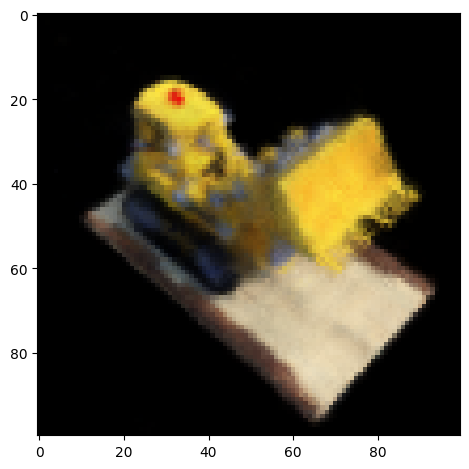

In [60]:
# тут должен появится трактор
imshow(rgb_predicted.detach().cpu().numpy())



---



# Домашнее задание № 15

Выполните все задания в этом ноутбуке

+ Мягкий дедлайн: `01.06.25 23:59`
+ Жесткий дедлайн: `08.06.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.